# Project : The price fluctuations of bitcoin

### (1) Loading local file into python environment

We have already excuted `Bitcoin_1_Download_Data.ipynb` file, and we have a `Bitcoin_data.csv` file under current path. Let's load the data into python environment:

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("./Bitcoin_data.csv")
df.head()

,date,price,supply,capital,trade,wiki
0,2017-05-02,1452.076288,16307212.5,2.367932e+10,8.630647e+07,17143
1,2017-05-03,1507.576857,16308862.5,2.458686e+10,9.876808e+07,17277
2,2017-05-04,1508.292125,16310962.5,2.460170e+10,1.786810e+08,19238
3,2017-05-05,1533.335071,16312575.0,2.501264e+10,1.366548e+08,16900
4,2017-05-06,1560.410200,16314675.0,2.545759e+10,6.890728e+07,17793


First of all, we need to display the data, and to find some interesting features:

In [2]:
trade2 = df.trade / df.price
trade2.name = "trade2"

ln_price = np.log(df.price)
ln_trade = np.log(df.trade)
ln_trade2 = np.log(trade2)
ln_wiki = np.log(df.wiki)

### (2) Let's try to draw some patterns from the data

Now, we first generate an "interpreted" variable, `y`, from the `price` attribute of dataframe `df`. We map the current price of bitcoin into a binary variable, 1 for 'going up' and -1 for 'going down', compared with the previous price. 

Also, we extract the explanary variables from dataframe `df`, and store them into a numpy array. We want to figure out the relation pattern of 'up' and 'down' with those explanatory variables.

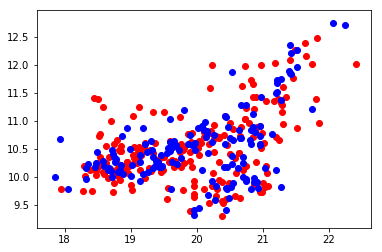

In [4]:
import matplotlib.pyplot as plt

y = df.price
y = y.diff()
y[y>0] = 1
y[y<0] = -1
y = y.values[1:len(y)-1]

attr1 = 'trade'
attr2 = 'wiki'

X = df.loc[0: len(y), [attr1, attr2]]

plt.scatter(np.log(X.loc[y>=0, attr1]).values, np.log(X.loc[y>=0, attr2]).values, c = 'r')
plt.scatter(np.log(X.loc[y<0, attr1]).values, np.log(X.loc[y<0, attr2]).values, c = 'b')
plt.show()

#### It seems we are in big trouble in predicting the price functuation!
Because there isn't any significant pattern that we are able to draw linearly from the figure above. It seems all the classical linear algorithms that we have learnt from the textbooks are invalid under this senario. We need to find some other ways to do prediction.

### (3) Using Time Series Models: ADL(autogressive dynamic lag) model

From economietrics course, we know the best time series model in the viewfield of econometrics is ADL model, which is given is this formation:

$$Y_t = \beta (1+L+L^2+...+L^{p-1})Y_{t-1}+\alpha (1+L+L^2+...+L^{p-1})X_{t-1}$$

ADL model may have a better performance in our case? Let find out. We have alredy written all the codes in the `LSTM.py` file (please check the file and look through our algoriths and ideas), and here we just display the result.

First, we split the total data into training sample and test sample:

In [5]:
from LSTM import Predictor
from LSTM import Utils

X = pd.DataFrame({'ln_trade':ln_trade, 'ln_trade2':ln_trade2, 'ln_wiki':ln_wiki})
p = Predictor()
sample_training = 200

train_set_X = X[:sample_training] 
train_set_Y = ln_price[:sample_training]
test_set_X = X[sample_training:]
test_set_Y = ln_price[sample_training:]

The accuracy for Pooled ADL : 

In [6]:
lag = 2

## (1) Train pure ADL
p.ADL_fit(train_set_Y, train_set_X, lag)
re_train = p.ADL_predict_accuracy(train_set_Y, train_set_X, lag)
## (2) Test pure ADL
re_test = p.ADL_predict_accuracy(test_set_Y, test_set_X, lag)
print('train_acc: ', re_train['accuracy'], '\ntest_accu: ', re_test['accuracy'])


train_acc:  0.5408163265306123 
test_accu:  0.546583850931677


### (4) Use LSTM (long and short term memory) Model

We have written all the code of this method in `LSTM.py` file, and here we just call the method and display the result.

In [7]:
## (1) Train LSTM

sample_training = 200
window = 50  # This parameter is the optimal after many tests.
lag = 2

train_re = p.LSTM_fit(train_set_Y, train_set_X, lag, window)

nperf1 = np.array(train_re['ADL_accuracy'])
nperf2 = np.array(train_re['LR_accuracy'])
print("Average trainning accuracy of Recursive ADL : ", nperf1.mean())
print("Average trainning accuracy of LSTM          : ", nperf2.mean())

## (2) Test LSTM
test_re = p.LSTM_predict_accuracy(test_set_Y, test_set_X, lag, window)
print("Test accuracy of LSTM                       : ", test_re['accuracy'])


Average trainning accuracy of Recursive ADL :  0.5263945578231293
Average trainning accuracy of LSTM          :  0.6006944444444444
Test accuracy of LSTM                       :  0.5757575757575758


### (4) Conclusion

Pooled ADL is stationary, and does not face overfitting problem. But the accuracy is just a little bit higher than 0.5, which is not a good performance.

LSTM is very sensitive to the input parameters, and the model can be overfitting in many cases, but it predict well under some optimal parameters.